<a href="https://colab.research.google.com/github/halim-jun/Ai_study/blob/master/20200806_Classification_tensorflow_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 총정리

1. 모델 : MobileNetV_2 의 convolution part 모두 차용. 그 외 Categorizatio layer 만 수정

2. 시각화 : 

- Epoch 당 validation/train loss/accuracy 확인 결과 epoch 2 부터 validation 상에서 모델의 개선 없음 
- 그러나 validation accuracy 가 80% 이상의 높은 수준으로 유지되었기때문에 그대로 수정없이 모델 사용해도 무방할 것으로 판단.

3. 총 accuracy 는 90%

#1. 모듈 임포트

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [7]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


#2. 데이터 다운로드 및 전처리

In [8]:
print(raw_train)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

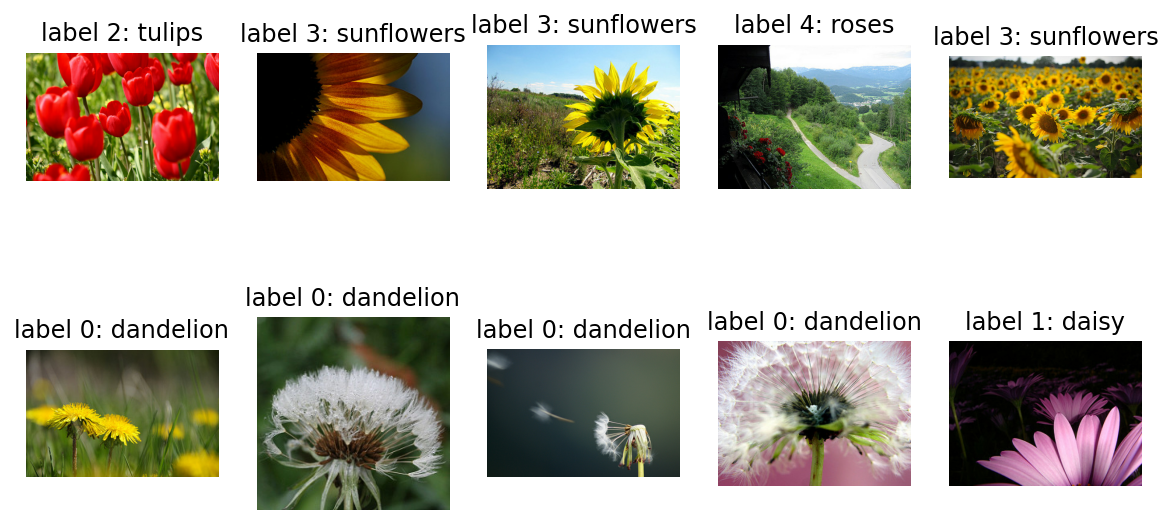

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)  
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 이미지 리사이징

In [11]:
raw_train.take(1)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  
    image = (image/127.5) - 1 #이미지의 픽셀값을 변경해 줍니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [13]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

## 리사이징 후 다시 시각화

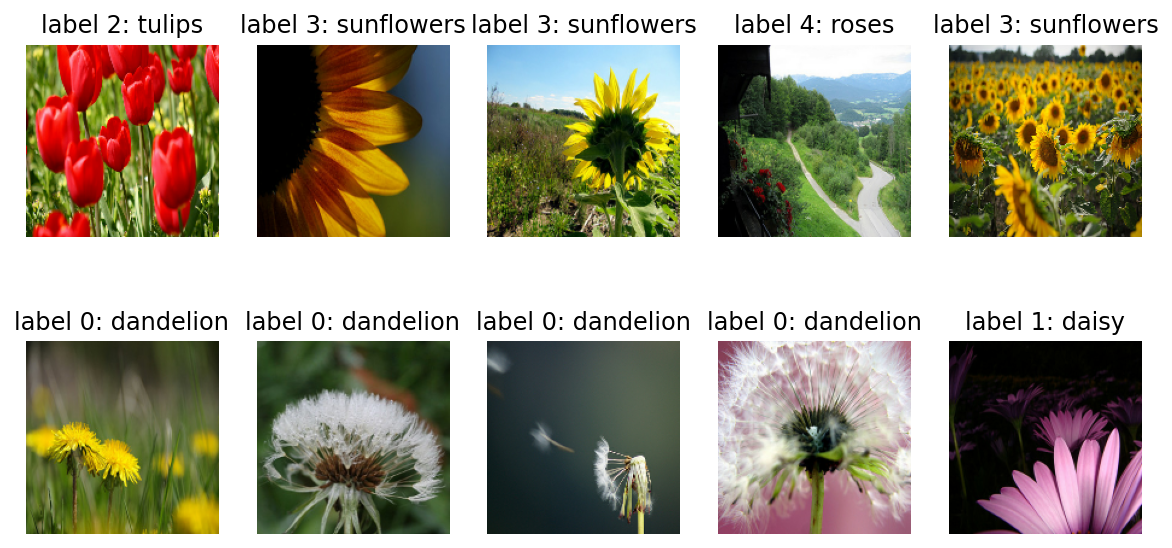

In [14]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow((image+1)/2) # 픽셀 이미지는 항상 양수  
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

#3. 데이터 랜덤 추출 batch 생성

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE) 
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

#4. Building Model

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE) 
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#Global average pooling (Dense layer 에 넣기 위해 데이터 shape 변경)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#Global average pooling (Dense layer 에 넣기 위해 데이터 shape 변경)

## 1) 모델 가져오기

In [15]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# Create the base model from the pre-trained model VGG16

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [23]:
feature_batch = base_model(image_batch)

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


## 3) Top layer 추가 구성

In [24]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# 실험 : feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


## 4) bottom layer (시작 ~ cateorize 전까지 - Convolutional layer) 끄기

In [26]:
base_model.trainable = False

## 5) 최종 모델 제작

In [27]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 658,437
Non-trainable params: 2,257,984
_________________________________________________________________


## 6) 모델 Compile

In [30]:
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

#5. Training

In [33]:
import time
start=time.time()
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)
end=time.time()
print(start-end)

Epoch 1/5
92/92 [==============================] - 67s 733ms/step - loss: 0.5729 - accuracy: 0.7912 - val_loss: 0.3722 - val_accuracy: 0.8692
Epoch 2/5
92/92 [==============================] - 68s 743ms/step - loss: 0.2500 - accuracy: 0.9193 - val_loss: 0.3249 - val_accuracy: 0.8910
Epoch 3/5
92/92 [==============================] - 68s 738ms/step - loss: 0.1621 - accuracy: 0.9506 - val_loss: 0.3350 - val_accuracy: 0.8883
Epoch 4/5
92/92 [==============================] - 69s 750ms/step - loss: 0.1067 - accuracy: 0.9758 - val_loss: 0.3311 - val_accuracy: 0.8801
Epoch 5/5
92/92 [==============================] - 71s 771ms/step - loss: 0.0691 - accuracy: 0.9857 - val_loss: 0.3386 - val_accuracy: 0.8856
-360.3534700870514


#6. Checking history

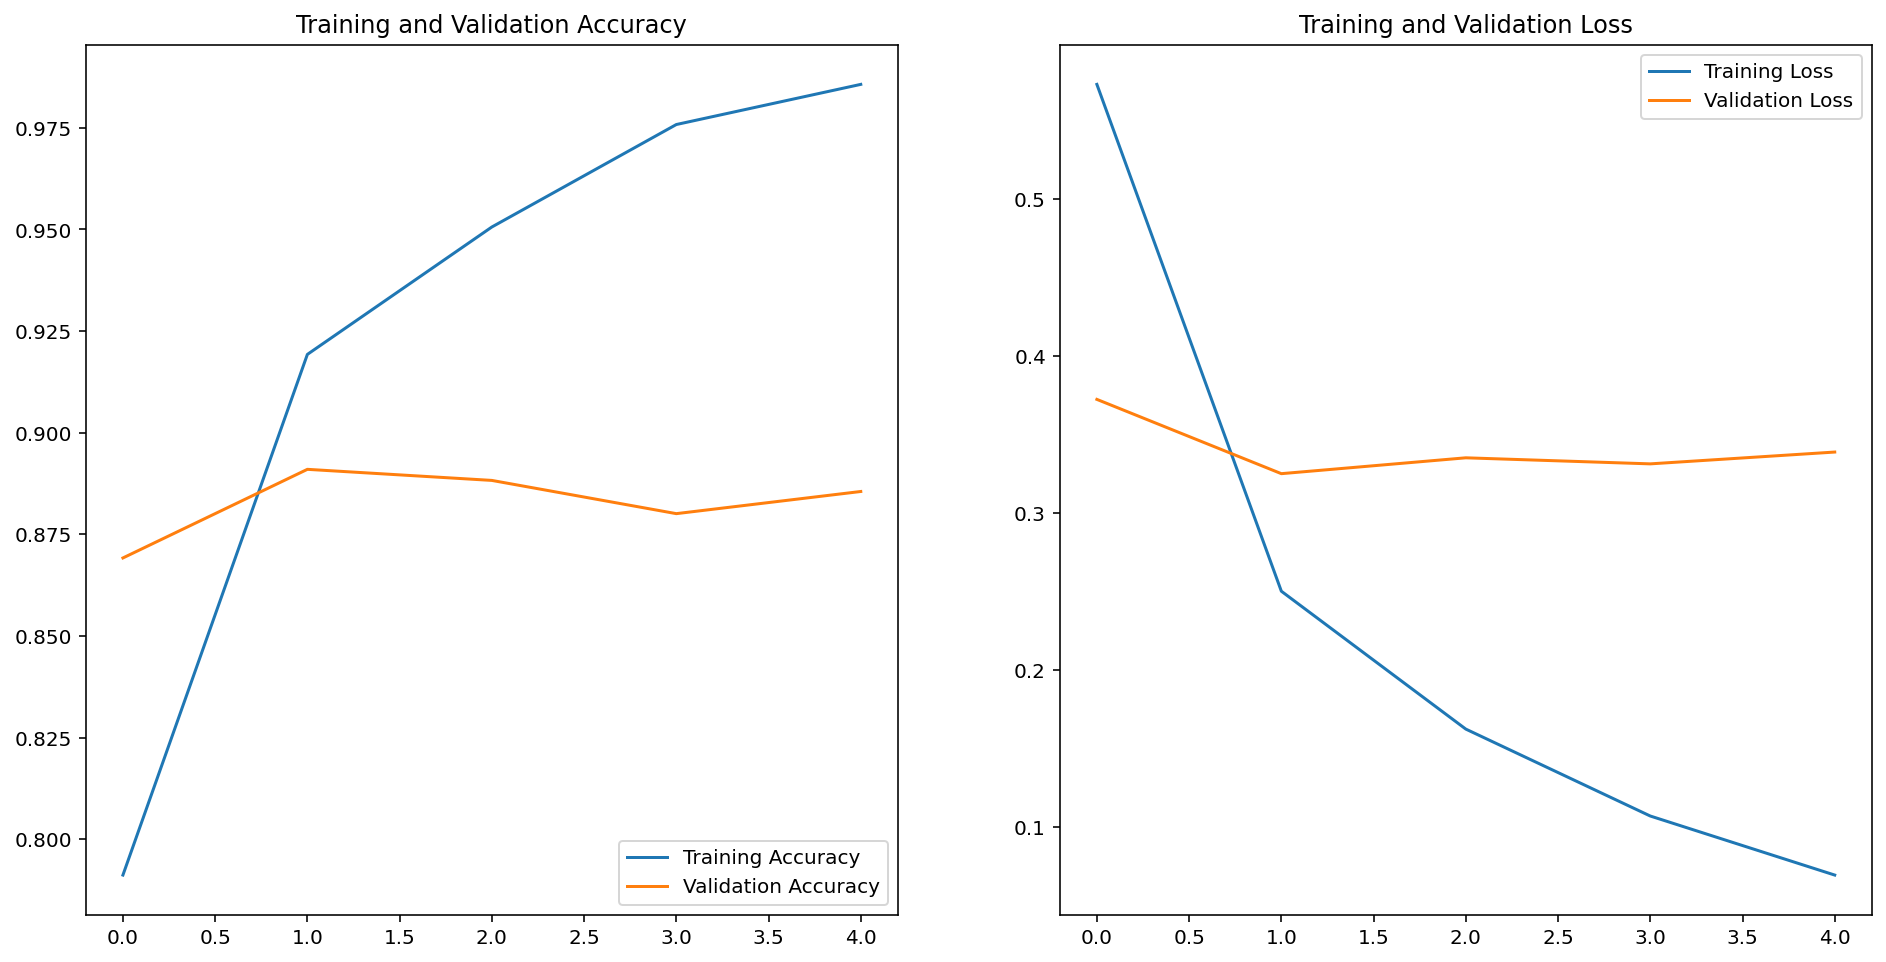

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
loss0, accuracy0 = model.evaluate(test_batches)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 6s 536ms/step - loss: 0.2626 - accuracy: 0.8992
loss: 0.26
accuracy: 0.90
